In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50 ,VGG16
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
root = '/kaggle/input/140k-real-and-fake-faces'

train_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
val_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [3]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)
target_size = (256,256)
batch_size = 32  # Update this according to your batch size

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
# Verify class distribution
print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", val_generator.class_indices)

Training class distribution: {'fake': 0, 'real': 1}
Validation class distribution: {'fake': 0, 'real': 1}


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout here
predictions = Dense(1,activation='sigmoid')(x)

model = Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable=True
    
model.compile(optimizer=Adam(learning_rate=1e-5),  # Fine-tuning usually requires a lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout here
predictions = Dense(1,activation='sigmoid')(x)

model = Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable=True
    
model.compile(optimizer=Adam(learning_rate=1e-5),  # Fine-tuning usually requires a lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    
)

Epoch 1/4


I0000 00:00:1739434968.037290     125 service.cc:145] XLA service 0x78c91c002620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739434968.037349     125 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1739434968.037353     125 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1739434983.759264     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 765s 235ms/step - accuracy: 0.6855 - loss: 0.5829 - val_accuracy: 0.8059 - val_loss: 0.4229
Epoch 2/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 682s 218ms/step - accuracy: 0.8108 - loss: 0.4111 - val_accuracy: 0.7479 - val_loss: 0.5197
Epoch 3/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 682s 218ms/step - accuracy: 0.8496 - loss: 0.3413 - val_accuracy: 0.8111 - val_loss: 0.4089
Epoch 4/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 681s 218ms/step - accuracy: 0.8823 - loss: 0.2816 - val_accuracy: 0.8288 - val_loss: 0.3926


In [10]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])

625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 301ms/step - accuracy: 0.9139 - loss: 0.2051
Test metrics: 0.8274999856948853


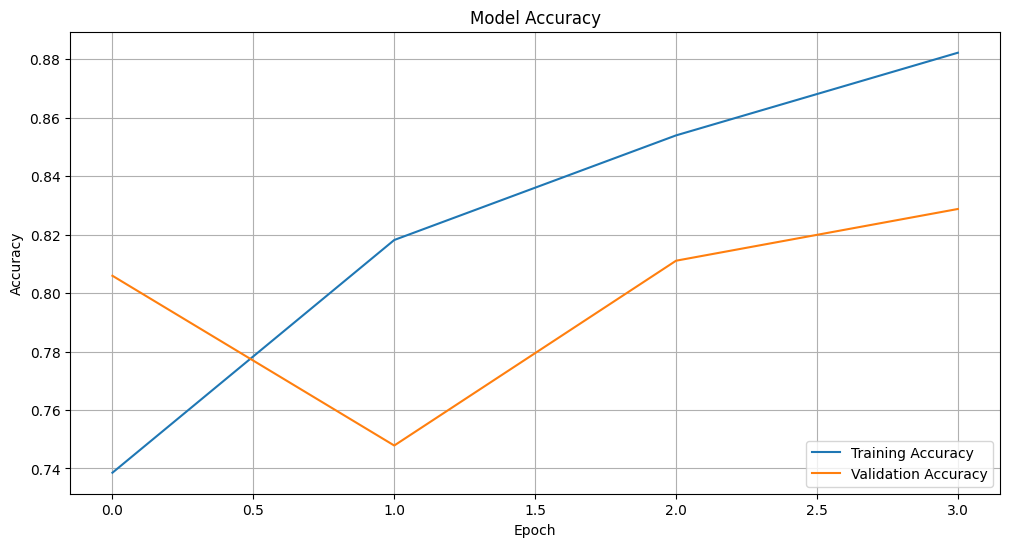

In [11]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

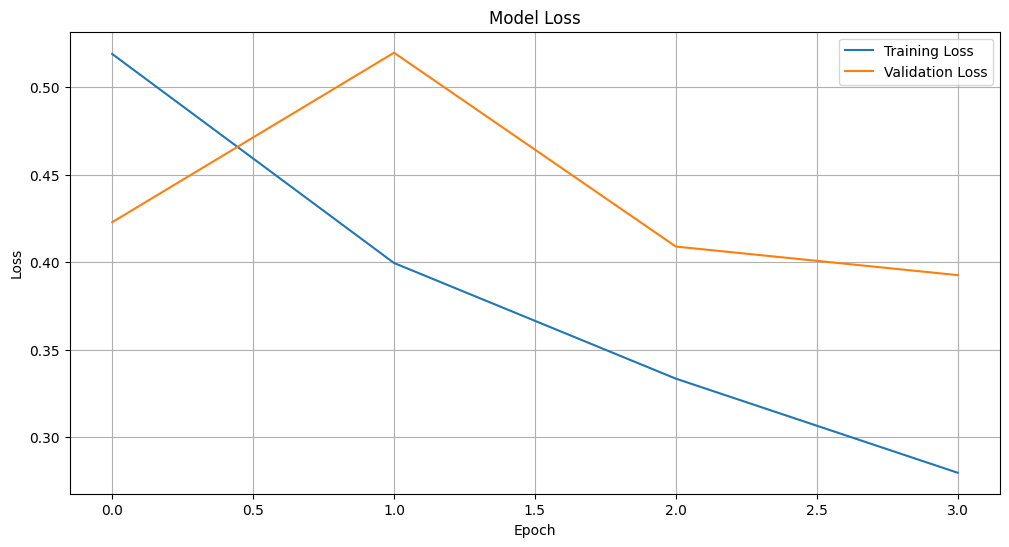

In [12]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [13]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 132ms/step
              precision    recall  f1-score   support

        fake       0.76      0.96      0.85     10000
        real       0.94      0.70      0.80     10000

    accuracy                           0.83     20000
   macro avg       0.85      0.83      0.82     20000
weighted avg       0.85      0.83      0.82     20000



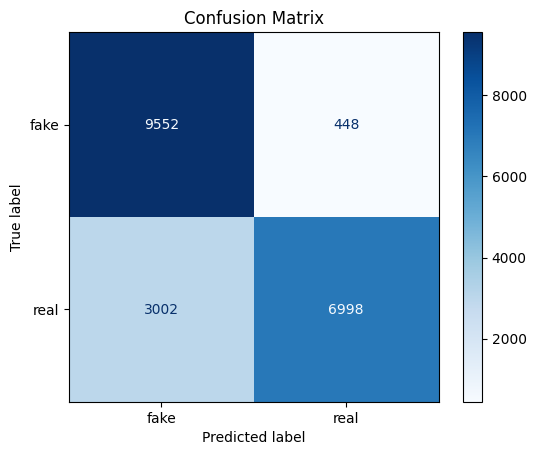

In [14]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert image to array
    img_array = image.img_to_array(img)
    
    # Rescale the image
    img_array = img_array / 255.0
    
    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)
    
    return img, img_array

# Provide the path to your image
img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/0K8CFMRZZ5.jpg'
target_size = (256, 256)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get the percentage for both classes
real_confidence = prediction[0][0] * 100
fake_confidence = (1 - prediction[0][0]) * 100

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"The model predicts this image is 'real' with a confidence of {real_confidence:.2f}%.")
print(f"The model predicts this image is 'fake' with a confidence of {fake_confidence:.2f}%.")

NameError: name 'model' is not defined

In [16]:
# Load VGG16 model with pre-trained weights, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-3:]:  # Unfreeze the last 4 layers (customize this as needed)
    layer.trainable = True

# Recompile the model after making layers trainable
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # You can reduce the learning rate further if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [1]:
# Define callbacks
callbacks = [
    #ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

NameError: name 'ReduceLROnPlateau' is not defined

In [2]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=callbacks
)

NameError: name 'model' is not defined

In [ ]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert image to array
    img_array = image.img_to_array(img)
    
    # Rescale the image
    img_array = img_array / 255.0
    
    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)
    
    return img, img_array

# Provide the path to your image
img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00093.jpg'
target_size = (256, 256)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get the percentage for both classes
real_confidence = prediction[0][0] * 100
fake_confidence = (1 - prediction[0][0]) * 100

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"The model predicts this image is 'real' with a confidence of {real_confidence:.2f}%.")
print(f"The model predicts this image is 'fake' with a confidence of {fake_confidence:.2f}%.")

In [ ]:

import os

# Check the current working directory
print(os.getcwd())

# Save the model
model.save('Vgg16_model.h5')

# List files in the current directory to confirm the save
print(os.listdir())


In [ ]:
# Save only the weights
model.save_weights('Vgg16_model.weights.h5')